# Optimisation bi-objective de Markowitz - Niveau 1

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sys

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination import get_termination

project_root = os.path.dirname(os.path.abspath(''))
raw_data = os.path.join(project_root, 'data', 'raw')
processed_data = os.path.join(project_root, 'data', 'processed')
images_path = os.path.join(project_root, 'reports', 'figures')

if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_prep import all_sectors

# Chargement des données
df = pd.read_csv(os.path.join(processed_data, 'daily_returns.csv'), index_col='Date', parse_dates=True)

In [2]:
# Calcul de Mu (Moyenne annualisée)
mu = df.mean() * 252 # 252 : jours de bourses dans une année

# Calcul de Sigma (Matrice de Covariance annualisée)
sigma = df.cov() * 252

print(f"Mu :\n{mu.head()}\nShape : {mu.shape}\n") 
print(f"Sigma :\n{sigma.head(1)}\nShape : {sigma.shape}")

Mu :
LIN    0.161983
APD    0.132600
ECL    0.123445
SHW    0.180060
PPG    0.055276
dtype: float64
Shape : (190,)

Sigma :
          LIN       APD       ECL       SHW       PPG       MLM       VMC  \
LIN  0.051981  0.038536  0.035775  0.031132  0.037482  0.034791  0.031276   

          NUE      STLD       FCX  ...      META      DIS      NFLX       VZ  \
LIN  0.041839  0.042712  0.058578  ...  0.031919  0.02813  0.027094  0.01394   

            T      TMUS     CMCSA      CHTR        EA      TTWO  
LIN  0.019061  0.021917  0.025355  0.022996  0.020016  0.022334  

[1 rows x 190 columns]
Shape : (190, 190)


### Fonctions Objectifs  f1, f2 et f3

In [3]:
# Fonction de cout f1 : Maximise le rendement (donc minimise -R)
def f1_rendement(w, mu):
    return -w.T @ mu

# Fonction de cout f2 : Minimise le risque (variance)
def f2_risque(w, sigma):
    return w.T @ sigma @ w

def f3_couts_de_transaction(w, w0, couts):
    return np.sum(np.abs(w - w0)) * couts

# Fonction utilitaire pour récupérer Rendement, Volatilité et Sharpe Ratio d'un poids w
def get_rend_vol_sr(w, mu, sigma):
    rend = w @ mu
    vol = np.sqrt(w.T @ sigma @ w)
    sr = rend / vol
    return rend, vol, sr

### Contraintes de base

In [4]:
num_assets = len(mu)
constraints_base = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1} # Somme(w) = 1
bounds = tuple((0, 1) for _ in range(num_assets)) # 0 <= w <= 1
K_TARGET = 10 # Nombre d'actions dans un portefeuille
transaction_cost = 0.005 # couts de transaction 0.5% de frais

# Initialisation : toutes les actions ont le meme poids
w0 = np.ones(num_assets) / num_assets

### Optimisation - Recherche du front de Pareto (NGSA II)

Le probleme technique que nous avons maintenant est que $C_{Base}$ (Somme = 1) est facile pour un solveur classique mais $C_{Op}$ (Cardinalité = K) complique fortement le problème car ça transforme le problème en un casse-tête combinatoire et donc en un problème non convexe que scipy.optimize.minimize ne peut pas résoudre directement.

In [6]:
class PortfolioProblem(ElementwiseProblem):
    def __init__(self, mu, sigma, w_prev, k_card, trans_cost=0.005):
        """
        Définition du problème pour Pymoo (NSGA-II)
        Objectifs : 3 (Rendement, Risque, Coûts)
        Variables : N (Poids des actifs)
        """
        self.mu = mu
        self.sigma = sigma
        self.w_prev = w_prev
        self.k_card = k_card
        self.trans_cost = trans_cost
        
        # On définit les bornes (0 à 1) et le nombre de variables
        super().__init__(n_var=len(mu), 
                         n_obj=3,     # f1, f2, f3
                         n_ieq_constr=0, # Pas de contrainte inéqualité classique car on répare en interne
                         xl=0.0, 
                         xu=1.0)

    def _evaluate(self, x, out, *args, **kwargs):
        """
        C'est ici que la magie opère.
        x : Le vecteur de poids proposé par l'algo génétique (pas encore propre)
        """
        
        # --- ETAPE 1 : Respecter C_Op (Cardinalité) ---
        # On identifie les indices des K plus grandes valeurs
        # argsort trie du plus petit au plus grand, on prend les K derniers
        idx_top_k = np.argsort(x)[-self.k_card:]
        
        # On crée un nouveau vecteur w propre avec des 0 partout
        w_clean = np.zeros_like(x)
        
        # On remet les valeurs seulement aux K endroits choisis
        w_clean[idx_top_k] = x[idx_top_k]
        
        # --- ETAPE 2 : Respecter C_Base (Somme = 1) ---
        # On normalise pour que la somme fasse exactement 1.0
        sum_w = np.sum(w_clean)
        if sum_w > 0:
            w_clean = w_clean / sum_w
        else:
            # Cas rare où l'algo propose que des 0, on met 1/K partout
            w_clean[idx_top_k] = 1.0 / self.k_card
            
        # --- ETAPE 3 : Calcul des 3 Objectifs ---
        
        # [cite_start]f1 : Maximiser Rendement (donc Minimiser -Rendement) [cite: 81]
        f1 = - (w_clean @ self.mu)
        
        # [cite_start]f2 : Minimiser Risque (Variance) [cite: 84]
        f2 = w_clean.T @ self.sigma @ w_clean
        
        # [cite_start]f3 : Minimiser Coûts de Transaction [cite: 88]
        # Somme des valeurs absolues des changements * coût unitaire
        turnover = np.sum(np.abs(w_clean - self.w_prev))
        f3 = turnover * self.trans_cost
        
        # On renvoie les 3 objectifs à minimiser
        out["F"] = [f1, f2, f3]
        
        # On renvoie aussi le "vrai" w utilisé (pour l'analyse plus tard)
        # Pymoo ne stocke pas ça par défaut, mais on n'en a pas besoin pour l'optim, juste pour le résultat final

In [8]:
problem = PortfolioProblem(
    mu=mu, 
    sigma=sigma, 
    w_prev=w0, 
    k_card=K_TARGET, 
    trans_cost=transaction_cost
)

In [9]:
# Configuration de l'algo
ngsa2 = NSGA2(pop_size=100) # il va tester 100 portefeuilles en parallèle à chaque génération

# Critère d'arrêt
termination = get_termination("n_gen", 200) # On lui laisse 200 générations pour s'améliorer (donc 20 000 tests au total)

print("Lancement de NSGA-II")

# Lancement de la simulation
res = minimize(problem,
               ngsa2,
               termination,
               seed=42,
               verbose=True)

print(f"\nTerminé, Solution trouvées : {len(res.X)}")

# res.F contient les valeurs des objectifs (f1, f2, f3) pour les meilleures solutions
# f1 est négatif (-Rendement), f2 est la variance, f3 est le coût

final_returns = -res.F[:, 0]            # On remet le rendement en positif
final_volatility = np.sqrt(res.F[:, 1]) # On passe de Variance à Volatilité (ecart-type = racine carrée de la variance)
final_costs = res.F[:, 2]               # Coûts de transaction

Lancement de NSGA-II
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     13 |             - |             -
     2 |      200 |     14 |  0.5000000000 |         ideal
     3 |      300 |     17 |  0.3333333333 |         nadir
     4 |      400 |     27 |  0.0809794774 |         ideal
     5 |      500 |     24 |  0.0360357796 |         ideal
     6 |      600 |     21 |  0.0651725831 |         ideal
     7 |      700 |     28 |  0.0055346934 |         ideal
     8 |      800 |     36 |  0.1532357395 |         ideal
     9 |      900 |     37 |  0.0235660713 |         ideal
    10 |     1000 |     39 |  0.0298945339 |         ideal
    11 |     1100 |     43 |  0.0456834362 |         ideal
    12 |     1200 |     49 |  0.0361377338 |         ideal
    13 |     1300 |     53 |  0.0169197910 |         ideal
    14 |     1400 |     52 |  0.0140683805 |         ideal
    15 |     1500 |     52 |  0.0189411419 |         ideal
    16 |     1600 |     61 |  0.010

### Visualisation du front de Pareto

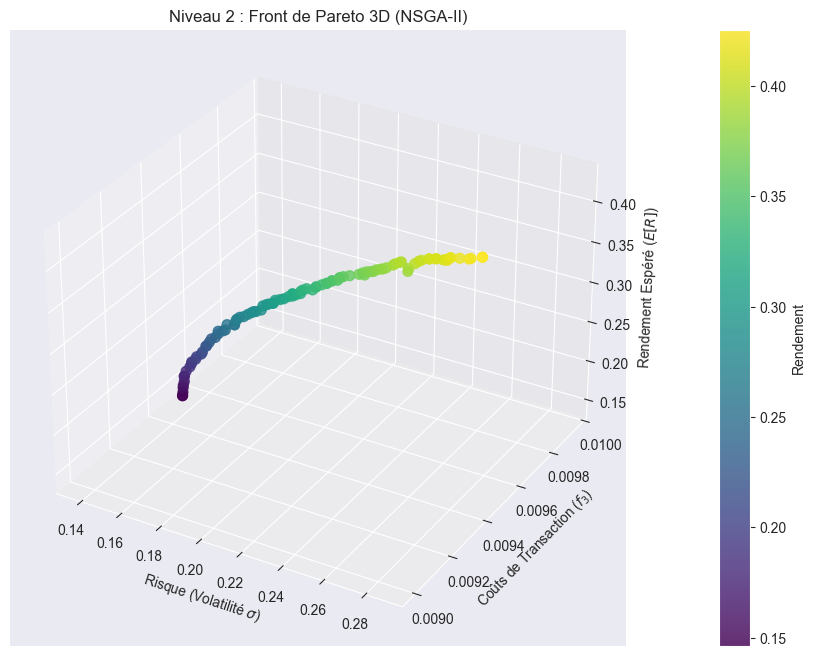

In [10]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(final_volatility, final_costs, final_returns, 
                c=final_returns, cmap='viridis', s=50, alpha=0.8) # Scatter Plot 3D

ax.set_xlabel(r'Risque (Volatilité $\sigma$)')
ax.set_ylabel('Coûts de Transaction ($f_3$)')
ax.set_zlabel('Rendement Espéré ($E[R]$)')
ax.set_title('Niveau 2 : Front de Pareto 3D (NSGA-II)')

plt.colorbar(sc, label='Rendement', pad=0.1)
plt.show()

In [21]:
import plotly.graph_objects as go

# On crée la figure 3D
fig = go.Figure(data=[go.Scatter3d(
    x=final_volatility,  # Axe X : Risque
    y=final_costs,       # Axe Y : Coûts
    z=final_returns,     # Axe Z : Rendement
    mode='markers',
    marker=dict(
        size=6,
        color=final_returns, # La couleur dépend du rendement
        colorscale='Viridis',
        opacity=0.8,
        colorbar=dict(title='Rendement')
    ),
    # Ce qui s'affiche quand on passe la souris
    hovertemplate=(
        "<b>Risque (σ):</b> %{x:.2%}<br>" +
        "<b>Coût (f3):</b> %{y:.4f}<br>" +
        "<b>Rendement:</b> %{z:.2%}<extra></extra>"
    )
)])

# Mise en page propre
fig.update_layout(
    title='Niveau 2 : Front de Pareto 3D Interactif (NSGA-II)',
    scene=dict(
        xaxis_title='Risque (Volatilité σ)',
        yaxis_title='Coûts de Transaction (f3)',
        zaxis_title='Rendement Espéré (E[R])'
    ),
    width=900,
    height=700,
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

# Exportation en HTML pour affichage dans le navigateur
output_path = os.path.join(images_path, "niveau_2_pareto_3d.html")
fig.write_html(output_path)


In [14]:
import plotly.graph_objects as go

# Création d'un graphique 2D avec la couleur représentant la 3ème dimension (Coûts)
# Solution de repli car le plot 3D pose des problèmes d'affichage WebGL dans certains environnements
fig_2d = go.Figure(data=[go.Scatter(
    x=final_volatility,  # Axe X : Risque
    y=final_returns,     # Axe Y : Rendement
    mode='markers',
    marker=dict(
        size=10,
        color=final_costs, # La couleur représente les coûts
        colorscale='Viridis',
        colorbar=dict(title='Coûts (f3)'),
        showscale=True,
        opacity=0.8
    ),
    hovertemplate=(
        "<b>Risque (σ):</b> %{x:.2%}<br>" +
        "<b>Rendement:</b> %{y:.2%}<br>" +
        "<b>Coût (f3):</b> %{marker.color:.4f}<extra></extra>"
    )
)])

fig_2d.update_layout(
    title='Niveau 2 : Front de Pareto 2D (Couleur = Coûts)',
    xaxis_title='Risque (Volatilité σ)',
    yaxis_title='Rendement Espéré (E[R])',
    width=900,
    height=600,
    margin=dict(l=40, r=40, b=40, t=40)
)

fig_2d.show()